In [12]:
#this is where single run functions such as creating the flat pickle file(flat database) and loading aligning spectra

from pipeline import import_aligning_spectra
from NRES_SHK_Pipeline import create_flat_dict_file

#Soon to be settings.xml
#Project folder directory on your computer
homePath = 'D:/My Documents/Coding Projects/nreshk/'

#required paths for pipeline, try not to change ever
dataPath = homePath + 'data/'
outputPath = homePath + 'output/'
flatPath = dataPath + 'flats/'
flatPickle = "flatDict.pkl"

create_flat_dict_file(flatPath,flatPickle)

#need this in memory for the following wrapper
#TODO maybe a better way to do this without lugging the lab spectra around every install
lab = import_aligning_spectra(dataPath+ 'LabSpectra/', resolution=0)#,res*10)
print('done')

done


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
100180 already has output
114710 already has output
115383 already has output
115404 already has output
120136 already has output
12235 already has output
126053 already has output
136202 already has output
149661 already has output
152391 already has output
154417 already has output
165341A already has output
17051 already has output
176051 already has output
182101 already has output
1835 already has output
187691 already has output
190406 already has output
194012 already has output
20630 already has output
206860 already has output
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 22049
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of observations: 49
-------------------------------------------------------------------------------
(3, 67, 4096)
MJD: 58761.9901174 and decYr 2019.76161676 w/ shk: 0.611996822

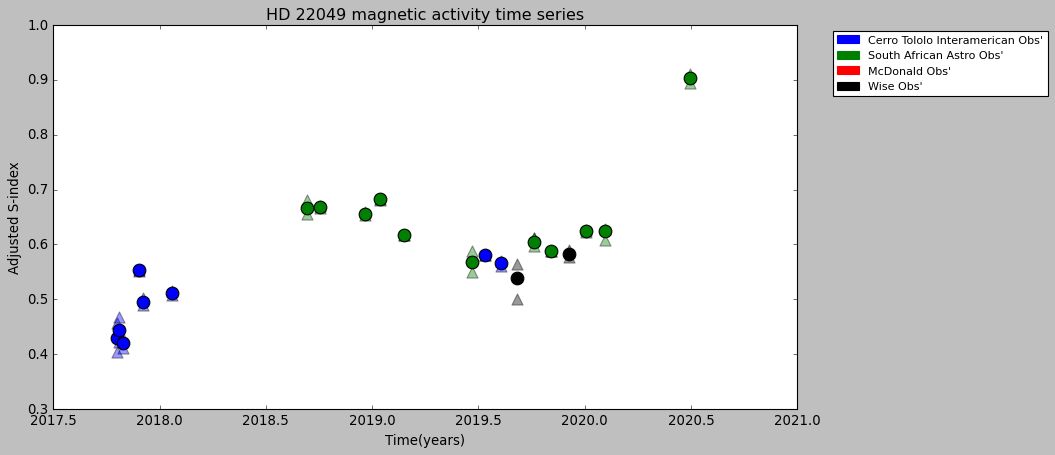

26913 already has output
30495 already has output
37394 already has output
43587 already has output
49933 already has output
75332 already has output
76151 already has output
78366 already has output
82443 already has output
82885 already has output
88737 already has output
98230B already has output
bad folder 'flats'
bad folder 'LabSpectra'


In [43]:
%load_ext autoreload
%autoreload


#from matplotlib.backends.backend_pdf import PdfPages
import NRES_SHK_Pipeline as nresshk
import pipeline_testing as t
import helpers as h


flatDict = nresshk.NRES_SHK_MkFlat(flatPath,flatPickle)


#MJD dates known to be bad TODO better feature use, maybe not w/ mjd
bad = [58330.3596906, 58330.3634695, 58553.7527935, 58553.7479017, 58272.4211262, 58272.4248934, 58354.2323109, 58354.2381758, 58331.3384727, 58331.3384727, 58331.342243, 58354.3656538, 58354.3715002, 58434.3511998, 58434.3561144,58354.3715002,58354.3656538,58331.342243]

#a list of stars we MUST run, regardless of if there is already output
forceRun = ["22049"]#["76151","22049"]["100180"]
    
#debug mode
#verbose debug
#file output|
#etc
debugMode = 0#currently N/A

#output mode
#0 - all output 
#1 - only star 
#2 - only time series N/A
#etc
h.pdfMode = 0
only=None
#only = [59030.1570547,59030.1619441]#for testing ONLY specific obs

#TODO impement|
#if using radial velocity to align must have dict of star HD's and their rv"
alignmentDict = []#currently N/A"

#t.test_daily_data_sum()

analyzedData = nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,bad,forceRun,only)


